In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
# For optimization using pygmo
import pygmo as pg
import numpy as np
from udp_initial_condition import udp_initial_condition

# For computing trajectory
from Trajectory import Trajectory

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

In [360]:
def setup_parameters():
    """Set up of required hyperparameters for the optimization scheme. 

    Returns:
        body_density (_float_): Body density of celestial body.
        target_altitude (_float_): Squared value of the satellite's orbital target altitude.
        final_time (_float_): Final time for the integration of trajectory.
        start_time (_float_): Start time for the integration of trajectory.
        time_step (_float_): Size of initial time step for integration of trajectory.
        lower_bounds (_np.ndarray_): Lower boundary values for the initial state vector.
        upper_bounds (_np.ndarray_): Lower boundary values for the initial state vector.
        algorithm (_int_): Choice of algorithm (see file Integrator for references).
        radius_bounding_sphere (_float_): Radius of the bounding sphere representing risk zone for collisions with celestial body.
        population_size (_int_): Number of chromosomes to compare at each generation.
        number_of_generations (_int_): Number of generations for the genetic opimization.
    """
    # Setup hyperparameters:
    body_density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    target_altitude = 8000**2           # Target altitude squared
    final_time = 20*3600.0              # Final time
    start_time = 0                      # Starting time
    time_step = 600                     # Time step size for trajectory propagation.
    radius_bounding_sphere = 5000       # Radius of the bounding sphere representing risk zone for collisions with celestial body.

    # Bounds for initial variable domain: [r_x,r_y,r_z,v_x,v_y,v_z]
    lower_bounds, upper_bounds = np.array([-10000,-10000,-10000,0,0,0]),np.array([10000,10000,10000,4.5,4.5,4.5])

    # Choose numerical integrator:
    algorithm = 3

    # Optimization parameters
    population_size = 10 #10
    number_of_generations = 32 #32

    return body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations

Retrieving user defined parameters...
Setting up the UDP...
Setting up the optimization algorithm...
1
2
3
4
5
6
7
8
9
10
Initializing the optimization:
11
12
13
14
15
16
17
18
19
20

   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    2.73716e+09       0.551641       0.722634        34725.5    1.40014e+10
21
22
23
24
25
26
27
28
29
30
      2             20    1.44244e+09       0.115563       0.279621        22632.7    1.11715e+10
31
32
33
34
35
36
37
38
39
40
      3             30    1.44244e+09       0.115563       0.279621        22632.7    1.11715e+10
41
42
43
44
45
46
47
48
49
50
      4             40    1.13452e+09       0.115563       0.279621        22632.7    1.14794e+10
51
52
53
54
55
56
57
58
59
60
      5             50    1.13452e+09       0.115563       0.279621        22632.9    1.09357e+10
61
62
63
64
65
66
67
68
69
70
      6             60    5.94454e+08       0.115563       0.279621        217

BokehModel(combine_events=True, render_bundle={'docs_json': {'a4e1da5f-2fe4-44c9-a614-5b8a6cdb2cf4': {'defs': …

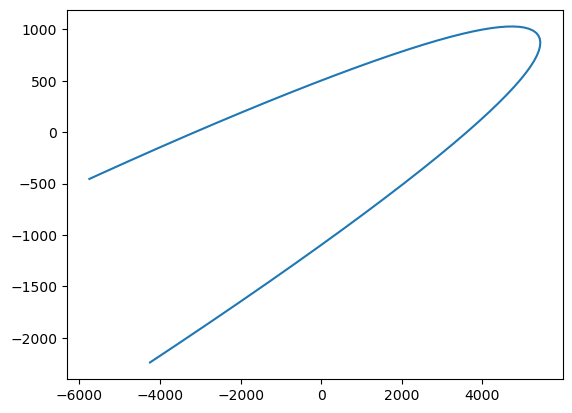

In [361]:
# Main script:

def run():
    """
    Main function for optimizing the initial state for deterministic trajectories around a 
    small celstial body using a mesh.
    """
    
    print("Retrieving user defined parameters...")
    body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations = setup_parameters()

    # Setup User-Defined Problem (UDP)
    print("Setting up the UDP...")
    udp = udp_initial_condition(body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere)
    prob = pg.problem(udp)

    # Setup optimization algorithm
    print("Setting up the optimization algorithm...")
    algo = pg.algorithm(pg.sade(gen = number_of_generations))
    pop = pg.population(prob = prob, size = population_size)
    
    # Run optimization
    print("Initializing the optimization:")
    algo.set_verbosity(1)
    pop = algo.evolve(pop)

    # Logs for output
    print("Champion fitness value: ", pop.champion_f) 
    print("Champion chromosome: ", pop.champion_x) 

    # Retrieving champion chromosome
    x = pop.champion_x

    # Compute optimized trajectory
    trajectory = Trajectory(body_density, final_time, start_time, time_step, algorithm, radius_bounding_sphere)
    trajectory_info, _, _  = trajectory.integrate(x)

    # Plot optimized trajectory
    trajectory.plot_trajectory(trajectory_info[0:3,:])

    plt.plot(trajectory_info[0,:],trajectory_info[1,:])

def main():
    run()

if __name__ == "__main__":
    cProfile.run("main()", "output.dat")

    with open("output_time.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("time").print_stats()
    
    with open("output_calls.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("calls").print_stats()


In [274]:
print(x)

[-2898.95682, -2215.36424, -8872.20606, 2.35387002, 0.494522253, 3.37286438]


In [ ]:
[-2.89895682e+03 -2.21536424e+03 -8.87220606e+03  2.35387002e+00
  4.94522253e-01  3.37286438e+00]

In [353]:
body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations = setup_parameters()

# Setup problem class
udp = udp_initial_condition(body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere)

# Working: x = [7.67318477e+03, 1.55888470e+00, 4.73749402e-01, 2.55865839e+00, 5.85351822e-01, 1.94775194e-01]
# x = [-2.89895682e+03, -2.21536424e+03, -8.87220606e+03, 2.35387002e+00, 4.94522253e-01, 3.37286438e+00]
# With new target alt:
x = [-2898.95682, -2215.36424, -8872.20606, 2.35387002, 0.494522253, 3.37286438]
#x = [0, -100, -2000, 2.35387002, 0.494522253, 3.37286438]

In [354]:
# Compute optimized trajectory
fitness_value, trajectory_info  = udp.compute_trajectory(x)

2


In [352]:
print(len(trajectory_info[:,0]))
print(trajectory_info.shape)
print("traj: ", trajectory_info)
print("fitness: ", fitness_value)



7
(7, 70)
traj:  [[-2.89895682e+03 -2.29924551e+03 -1.65612739e+03 -1.08905260e+03
  -5.86055078e+02 -1.24414353e+02  2.72034859e+02  6.26635295e+02
   9.49364036e+02  1.24393353e+03  1.50045263e+03  1.67011227e+03
   1.80273792e+03  1.93992005e+03  2.05662274e+03  2.15606602e+03
   2.24148684e+03  2.31336661e+03  2.39101392e+03  2.48184402e+03
   2.57506209e+03  2.68266211e+03  2.79690345e+03  2.91529234e+03
   3.03566018e+03  3.14966216e+03  3.26751454e+03  3.39104771e+03
   3.53262494e+03  3.69348180e+03  3.87124691e+03  4.07972450e+03
   4.32613542e+03  4.60340105e+03  4.91434326e+03  5.25848917e+03
   5.63519985e+03  6.04787553e+03  6.50434591e+03  7.01628292e+03
   7.56486027e+03  8.16036617e+03  8.81175747e+03  9.52817795e+03
   1.03229408e+04  1.12087327e+04  1.21984135e+04  1.33081153e+04
   1.45562961e+04  1.59640215e+04  1.75520291e+04  1.93512240e+04
   2.13917242e+04  2.37164028e+04  2.63631423e+04  2.93866689e+04
   3.28434054e+04  3.67637558e+04  4.12473873e+04  4.639502

In [255]:
print(trajectory_info[:,-1])

[1.50785528e+05 4.06023645e+04 2.40282542e+05 2.12325325e+00
 5.97031347e-01 3.45715887e+00 7.20000000e+04]


BokehModel(combine_events=True, render_bundle={'docs_json': {'d6a4b49e-701d-4926-9ece-299c895ba693': {'defs': …

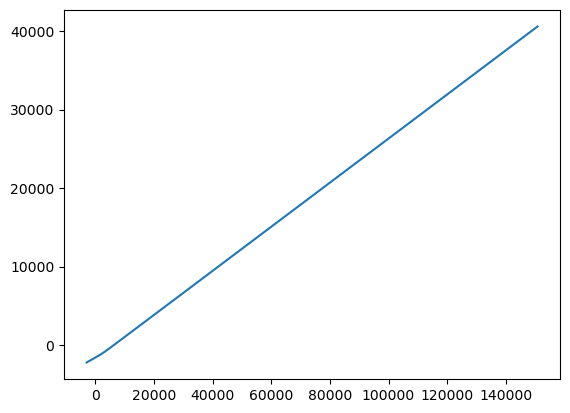

In [256]:
# Plot optimized trajectory
udp.plot_trajectory(trajectory_info[0:3,:])

plt.plot(trajectory_info[0,:],trajectory_info[1,:])